In [123]:
df = pd.read_csv("./annotated_data/train_annotation.csv")
df.head()

,img_name,label,x_min,y_min,x_max,y_max
0,training_images/8d02117d-6c71-4e47-b50a-6cc8d5...,red blood cell,1440,1057,1540,1158
1,training_images/8d02117d-6c71-4e47-b50a-6cc8d5...,red blood cell,1303,868,1403,971
2,training_images/8d02117d-6c71-4e47-b50a-6cc8d5...,red blood cell,900,578,1008,689
3,training_images/8d02117d-6c71-4e47-b50a-6cc8d5...,red blood cell,611,304,713,408
4,training_images/8d02117d-6c71-4e47-b50a-6cc8d5...,red blood cell,881,198,1003,312


In [124]:
boxes_stacked_train = {}

In [125]:
for i in range(df.shape[0]):
    img = str("annotated_data/" + df["img_name"][i])
    startX, startY, endX, endY = int(df["x_min"][i]), int(df["y_min"][i]), int(df["x_max"][i]), int(df["y_max"][i])
    
    if img in boxes_stacked_train:
        boxes_stacked_train[img].append(
            [startX, startY, endX, endY])
    else:
        boxes_stacked_train[img] = [
            [startX, startY, endX, endY]]

In [126]:
import json
with open('./output/records/ground_truth_boxes.json', 'w+') as fp:
    json.dump(boxes_stacked_train, fp, separators=(',', ':'), sort_keys=True, indent=4)

avg precision of0.5000: 0.8860
avg precision of0.5500: 0.8084
avg precision of0.6000: 0.8079
avg precision of0.6500: 0.8067
avg precision of0.7000: 0.8026
avg precision of0.7500: 0.7842
avg precision of0.8000: 0.6538
avg precision of0.8500: 0.4058
avg precision of0.9000: 0.1699
avg precision of0.9500: 0.0114
map: 61.37
avg precs:  [0.886, 0.8084, 0.8079, 0.8067, 0.8026, 0.7842, 0.6538, 0.4058, 0.1699, 0.0114]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 5427.8192 secs


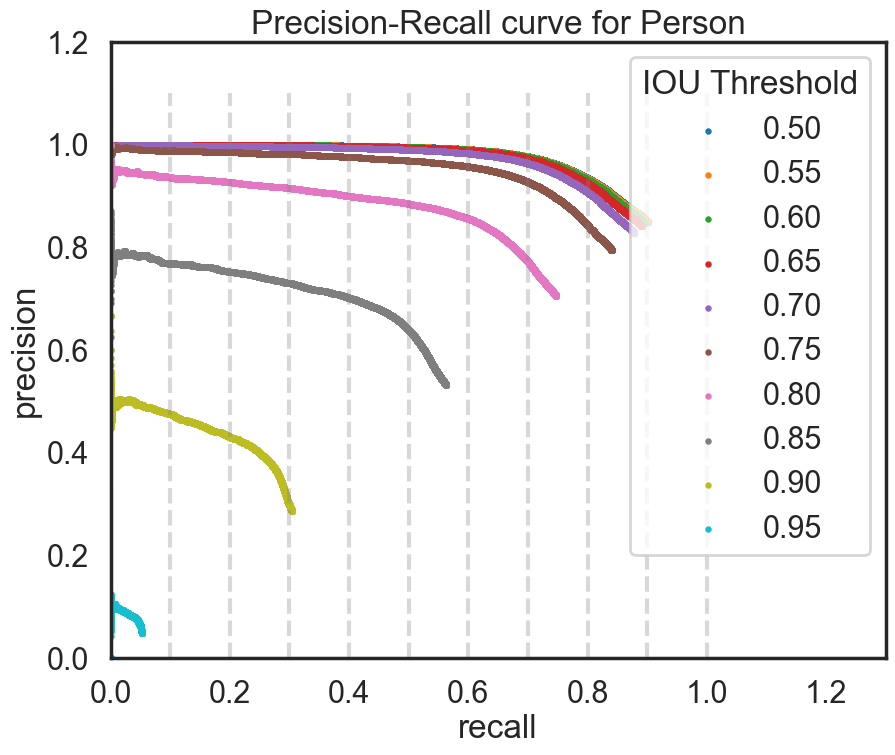

In [2]:
from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
# basic concept for calculation of IOU is that we will define some thresold and then for each predicted box we will calculate IOU with each ground truth box and then only consider IOU greater than that IOU thresold

def calc_iou_individual(pred_box, gt_box):
    # this function calculates the IOU scores of each predicted and ground truth bounding box and returns the IOU.
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)  # calculating the intersection area using far near values of predicted and ground truth boxes 
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)  # calculating the ground truth bounding box area
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1) # calculation the predicted box area
    iou = inter_area / (true_box_area + pred_box_area - inter_area) # calculating the IOU
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    # This Function uses calc_iou_individual to calculate IOU of all the objects and then return TF,FP,FN
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    # if there is no predicited bounding boxes then returning TP,FP,FN=0
    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = [] 
    pred_idx_thr = []
    ious = []
    # calcuates IOU of each bouding box and appends into ious 
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb) # storing index of ground truth boxes which has higher iou than thresold with pred boxes 
                pred_idx_thr.append(ipb) # storing index of pred boxes which has higher iou than thresold with ground truth boxes 
                ious.append(iou) # appending to ious those iou only which are higher than thresold

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        # calculating TF,FP,FN according to matches of boxes index which we stored 
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    # This Function calculates precision recall for images using get_single_image_results function that returns TP,FP,FN
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

def get_model_scores_map(pred_boxes):
    # this fn maps scores with images
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    # this fn calculates avg_precision from the precision we got from calc_precision_recall with respective IOU threshold 
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s = 7, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax


if __name__ == "__main__":

    with open('./output/records/ground_truth_boxes.json') as infile:
        gt_boxes = json.load(infile)
#         print(gt_boxes.keys())

    with open('./output/records/predicted_boxes_stacked_train.json') as infile:
        pred_boxes = json.load(infile)
#         print(pred_boxes.keys())

    # Runs it for one IoU threshold
#     iou_thr = 0.5
#     start_time = time.time()
#     data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr) # calculating avg_precision for ground truth and predicted bounding boxes
#     end_time = time.time()
#     print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
#     print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)): # calculating avg_precision for differnct IOU thresolds
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        print('avg precision of{:.4f}: {:.4f}'.format(iou_thr, data['avg_prec']))
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']
        ax = plot_pr_curve(
            precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)
    plt.legend(loc='upper right', title='IOU Threshold', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    plt.show()